# **Libraries**

In [ ]:
# #Connexion préalable à mon Google Drive afin de charger les données
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import cv2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
import os
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
from os import listdir
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
from skimage.io import imread, imshow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# **Préparation du dataset**

## Encodage de la colonne 'label'

In [ ]:
ecomm_label_clean =  pd.read_csv("ecomm_label_clean.csv")
print(ecomm_label_clean.shape)

ecomm_label_clean.head(1)

(1050, 11)


,uniq_id,crawl_timestamp,product_name,retail_price,image,description,brand,label,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,Elegance Polyester Multicolor Abstract Eyelet ...,1899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...


In [ ]:
#Encodage de la colonne 'label'
#bibliothèque Python scikit-learn qui est utilisée pour convertir des variables catégorielles en variables numériques.

le = preprocessing.LabelEncoder()
le.fit(ecomm_label_clean["label"])
ecomm_label_clean["label_enco"] = le.transform(ecomm_label_clean["label"])


In [ ]:
ecomm_label_clean.head()

,uniq_id,crawl_timestamp,product_name,retail_price,image,description,brand,label,sentence_bow,sentence_bow_lem,sentence_dl,label_enco
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,Elegance Polyester Multicolor Abstract Eyelet ...,1899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,Sathiyas Cotton Bath Towel,600.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,0
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,Eurospa Cotton Terry Face Towel Set,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...,0
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,SANTOSH ROYAL FASHION Cotton Printed King size...,2699.0,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,Home Furnishing,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...,4
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,Jaipur Print Cotton Floral King sized Double B...,2599.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,Home Furnishing,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...,4


In [ ]:
names_pie = ecomm_label_clean['label'].unique()

In [ ]:
#Nous avons 7 catégories de label avec une répartition équitable pour chacun 
ecomm_pie = ecomm_label_clean.groupby("label_enco").count()
ecomm_pie

,uniq_id,crawl_timestamp,product_name,retail_price,image,description,brand,label,sentence_bow,sentence_bow_lem,sentence_dl
label_enco,,,,,,,,,,,
0,150,150,150,149,150,150,134,150,150,150,150
1,150,150,150,150,150,150,41,150,150,150,150
2,150,150,150,150,150,150,150,150,150,150,150
3,150,150,150,150,150,150,148,150,150,150,150
4,150,150,150,150,150,150,150,150,150,150,150
5,150,150,150,150,150,150,79,150,150,150,150
6,150,150,150,150,150,150,10,150,150,150,150


In [ ]:
#Répartition équitable des produits dans chaque catégorie de label
fig = px.pie(ecomm_pie, values='uniq_id', names=names_pie, title='Répartition des produits en fonction des catégories de label')
fig.update_layout(legend=dict(title='Catégories de labels'))
fig.show()

## Ajout d'un chemin d'accès pour chaque image

In [ ]:
list_labels = ecomm_label_clean['label'].unique()

In [ ]:
list_labels

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [ ]:
list_url_image = ecomm_label_clean['image'].unique()

In [ ]:
# charger les noms des fichiers d'images dans une liste
file_names = list_url_image

# créer une dataframe à partir de la liste de noms de fichiers
image_df = pd.DataFrame({'image_name': file_names})

# ajouter un nouveau chemin d'accès pour chaque image
folder_path = r'C:\Users\dalila.derdar.ONCEFORALL\OneDrive\OneDrive - ALG\Bureau\Projet 6 VS Studio\Images'#dossier où sont stockés mes images en local
image_df['image_path'] = folder_path + '//' + image_df['image_name'].apply(str)#création de la nouvelle colonne 


# concaténer la dataframe avec la colonne 'image_path' à la dataframe existante
ecomm_label_image = pd.concat([ecomm_label_clean, image_df], axis=1)

In [ ]:
ecomm_label_image.head(3)

,uniq_id,crawl_timestamp,product_name,retail_price,image,description,brand,label,sentence_bow,sentence_bow_lem,sentence_dl,label_enco,image_name,image_path
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,Elegance Polyester Multicolor Abstract Eyelet ...,1899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,4,55b85ea15a1536d46b7190ad6fff8ce7.jpg,C:\Users\dalila.derdar.ONCEFORALL\OneDrive\One...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,Sathiyas Cotton Bath Towel,600.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,0,7b72c92c2f6c40268628ec5f14c6d590.jpg,C:\Users\dalila.derdar.ONCEFORALL\OneDrive\One...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,Eurospa Cotton Terry Face Towel Set,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...,0,64d5d4a258243731dc7bbb1eef49ad74.jpg,C:\Users\dalila.derdar.ONCEFORALL\OneDrive\One...


In [ ]:
import os
from PIL import Image

MAX_IMAGE_SIZE = 89478485

def check_image_size(image_path):
    with Image.open(image_path) as img:
        image_size = img.size[0] * img.size[1]
        if image_size > MAX_IMAGE_SIZE:
            return image_path

image_dir = r'C:\Users\dalila.derdar.ONCEFORALL\OneDrive\OneDrive - ALG\Bureau\Projet 6 VS Studio\Images'
large_images = []

for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_dir, filename)
        large_image = check_image_size(image_path)
        if large_image:
            large_images.append(large_image)

print("Images dont la taille dépasse la limite autorisée :")
for image in large_images:
    print(image)

Images dont la taille dépasse la limite autorisée :


In [ ]:
ecomm_label_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uniq_id           1050 non-null   object 
 1   crawl_timestamp   1050 non-null   object 
 2   product_name      1050 non-null   object 
 3   retail_price      1049 non-null   float64
 4   image             1050 non-null   object 
 5   description       1050 non-null   object 
 6   brand             712 non-null    object 
 7   label             1050 non-null   object 
 8   sentence_bow      1050 non-null   object 
 9   sentence_bow_lem  1050 non-null   object 
 10  sentence_dl       1050 non-null   object 
 11  label_enco        1050 non-null   int32  
 12  image_name        1050 non-null   object 
 13  image_path        1050 non-null   object 
dtypes: float64(1), int32(1), object(12)
memory usage: 110.9+ KB


In [ ]:
ecomm_label_image.loc[ecomm_label_image['image_path'] == 'C:\\Users\\dalila.derdar.ONCEFORALL\\OneDrive\\OneDrive - ALG\\Bureau\\Projet 6 VS Studio\\Images//5518124b75d6c6dfee4c2e4c0cfa716a.jpg']

,uniq_id,crawl_timestamp,product_name,retail_price,image,description,brand,label,sentence_bow,sentence_bow_lem,sentence_dl,label_enco,image_name,image_path
677,5518124b75d6c6dfee4c2e4c0cfa716a,2015-12-31 09:19:31 +0000,"Simoco 7 W, 9 W, 12 W LED Bulb",897.0,5518124b75d6c6dfee4c2e4c0cfa716a.jpg,"Buy Simoco 7 W, 9 W, 12 W LED Bulb for Rs.829 ...",Simoco,Kitchen & Dining,buy simoco led bulb rs.829 online simoco led b...,buy simoco led bulb rs.829 online simoco led b...,"buy simoco 7 w , 9 w , 12 w led bulb for rs.82...",5,5518124b75d6c6dfee4c2e4c0cfa716a.jpg,C:\Users\dalila.derdar.ONCEFORALL\OneDrive\One...


In [ ]:
# Supprimer la ligne d'index 677 dans le DataFrame train_sample
ecomm_label_image = ecomm_label_image.drop(677)

# Afficher le DataFrame après suppression de la ligne
ecomm_label_image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049 entries, 0 to 1049
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uniq_id           1049 non-null   object 
 1   crawl_timestamp   1049 non-null   object 
 2   product_name      1049 non-null   object 
 3   retail_price      1048 non-null   float64
 4   image             1049 non-null   object 
 5   description       1049 non-null   object 
 6   brand             711 non-null    object 
 7   label             1049 non-null   object 
 8   sentence_bow      1049 non-null   object 
 9   sentence_bow_lem  1049 non-null   object 
 10  sentence_dl       1049 non-null   object 
 11  label_enco        1049 non-null   int32  
 12  image_name        1049 non-null   object 
 13  image_path        1049 non-null   object 
dtypes: float64(1), int32(1), object(12)
memory usage: 118.8+ KB


In [ ]:
ecomm_label_image.reset_index(drop=True, inplace=True)

## Afficher les 3 premières images de chaque catégorie de labels

Home Furnishing


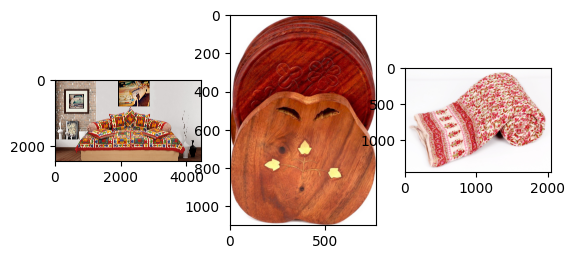

Baby Care


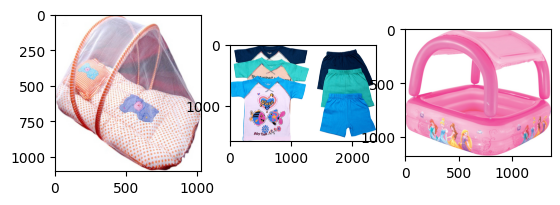

Watches


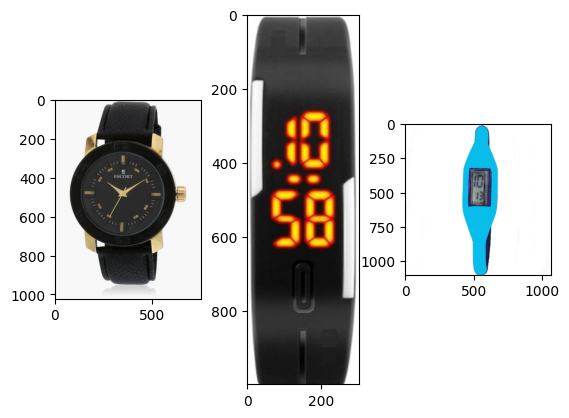

Home Decor & Festive Needs


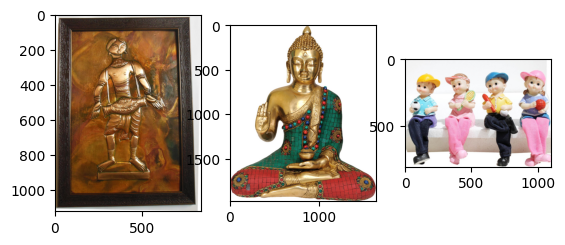

Kitchen & Dining


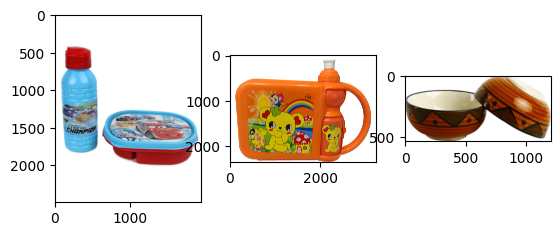

Beauty and Personal Care


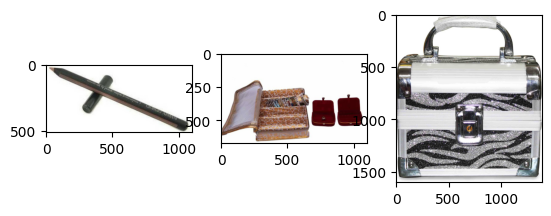

Computers


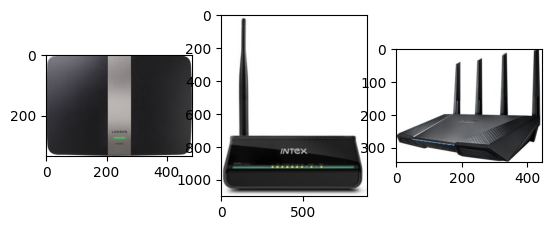

In [ ]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [ecomm_label_image["image_path"][i] for i in range(len(ecomm_label_image)) if ecomm_label_image["label"][i]==name]
    return list_image_name

list_Home_Furnishing =[ecomm_label_image["image_path"][i] for i in range(len(ecomm_label_image)) if ecomm_label_image["label"][i]=="Home Furnishing"]
list_Baby_Care=[ecomm_label_image["image_path"][i] for i in range(len(ecomm_label_image)) if ecomm_label_image["label"][i]=="Baby Care"]
list_Watches=[ecomm_label_image["image_path"][i] for i in range(len(ecomm_label_image)) if ecomm_label_image["label"][i]=="Watches"]
list_Home_Decor_Festive_Needs=[ecomm_label_image["image_path"][i] for i in range(len(ecomm_label_image)) if ecomm_label_image["label"][i]=="Home Decor & Festive Needs"]
list_Kitchen_Dining=[ecomm_label_image["image_path"][i] for i in range(len(ecomm_label_image)) if ecomm_label_image["label"][i]=="Kitchen & Dining"]
list_Beauty_Personal_Care=[ecomm_label_image["image_path"][i] for i in range(len(ecomm_label_image)) if ecomm_label_image["label"][i]=="Beauty and Personal Care"]
list_Computers=[ecomm_label_image["image_path"][i] for i in range(len(ecomm_label_image)) if ecomm_label_image["label"][i]=="Computers"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# **Etape 1 : étude de faisabilité**

## Modèle SIFT 

*Scale-invariant feature transform*

Permet d'extraire des features (ou points d'intérêt) de l'image et de calculer leurs descripteurs. 

Un descripteur est un vecteur qui décrit le voisinage de la feature à laquelle il est associé. Il est utilisé pour repérer les paires de features qui se ressemblent le plus dans deux images.

L'étape de matching revient alors à comparer les descripteurs.

Se divise en plusieurs étapes :

**1.Détection** : 
Chaque feature est une zone circulaire intéressante, repérée par son centre (point d'intérêt), et dont le rayon est proportionnel à son échelle caractéristique. La force du détecteur SIFT est sa capacité à trouver des rayons différents, et donc des features de différentes tailles.

*Création de l'espace des échelles*
consiste à flouter notre image (avec un filtre gaussien) et à réduire sa taille plusieurs fois


*Calcul des DoG*
Difference of Gaussians" (différence des Gaussiennes) désigne une image obtenue en faisant la soustraction de deux images successives (deux flous Gaussiens de paramètres σ et kσ) dans une octave.
calcule les DoG pour chaque paire d'images consécutives


*Localisation des points d'intérêt* 


**2.Description** : 

*assignation d'orientation*consiste à déterminer l'orientation de chacun des points d'intérêts afin de rendre le descripteur invariant par rotation. L'orientation d'un point d'intérêt est la direction du gradient la plus rencontrée autour de ce point.

*création des descripteurs*


==> En pratique, on utilise seulement SIFT pour détecter et décrire les features.



**Etape1** = extaction des features avec SIFT(détection et description)

In [ ]:
sample_train_data = ecomm_label_image.sample(frac=0.1, random_state=42)

In [ ]:
sample_train_data.reset_index(drop=True, inplace=True)

In [ ]:
# Diviser le dataset en train et test
train_sample, test_sample = train_test_split(sample_train_data, test_size=0.3, random_state=42)

# Afficher la taille des ensembles de train et test
print("Taille de l'ensemble de train:", len(train_sample))
print("Taille de l'ensemble de test:", len(test_sample))

Taille de l'ensemble de train: 73
Taille de l'ensemble de test: 32


In [ ]:
import cv2
import pandas as pd
import numpy as np

# Chargement des images

images = []
for path in train_sample['image_path']:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #redimesionnement de l'image avec reshape ou resize (256x256)
    img = cv2.resize(img, (256, 256))
    images.append(img)

# Initialisation de l'extracteur de descripteurs SIFT
sift = cv2.SIFT_create()

# Extraction des descripteurs SIFT pour chaque image
descriptors = []
for img in images:
    kp, des = sift.detectAndCompute(img, None)
    descriptors.append(des)

# # Empilement des descripteurs en une seule matrice
descriptors = np.concatenate(descriptors, axis=0)

In [ ]:
descriptors = np.array(descriptors)
print(descriptors.ndim)

2



**Etape2** = Création des bag-of-features


In [ ]:
labels = train_sample.label.sort_values().unique()
img_path = train_sample['image_path']

In [ ]:
from sklearn.cluster import MiniBatchKMeans
k =7 
batch_size = np.size(img_path) * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(descriptors)

c:\Users\dalila.derdar.ONCEFORALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Init 1/3 with method k-means++
Inertia for init 1/3: 124104688.0
Init 2/3 with method k-means++
Inertia for init 2/3: 127429944.0
Init 3/3 with method k-means++
Inertia for init 3/3: 135712704.0
Minibatch step 1/10218: mean batch inertia: 193183.56164383562
Minibatch step 2/10218: mean batch inertia: 122970.44748858447, ewa inertia: 122970.44748858447
Minibatch step 3/10218: mean batch inertia: 120571.83561643836, ewa inertia: 122923.50414631458
Minibatch step 4/10218: mean batch inertia: 122228.19178082192, ewa inertia: 122909.89615631968
Minibatch step 5/10218: mean batch inertia: 116904.100456621, ewa inertia: 122792.35645495828
Minibatch step 6/10218: mean batch inertia: 117966.2100456621, ewa inertia: 122697.90372362353
Minibatch step 7/10218: mean batch inertia: 114717.69863013699, ewa inertia: 122541.72276602982
Minibatch step 8/10218: mean batch inertia: 116967.02283105023, ewa inertia: 122432.62005952754
Minibatch step 9/10218: mean batch inertia: 113898.77625570777, ewa inert

In [ ]:

histograms = {}

# Boucle sur chaque image pour créer l'histogramme correspondant
for i, img in enumerate(images):
    # Extraction des descripteurs SIFT pour l'image
    kp, des = sift.detectAndCompute(img, None)
    
    # Attribution de chaque descripteur à un cluster
    labels = kmeans.predict(des)
    
    # Comptage du nombre de descripteurs affectés à chaque cluster
    counts = np.bincount(labels, minlength=kmeans.n_clusters)
    
    # Création de l'histogramme
    histograms[i] = counts

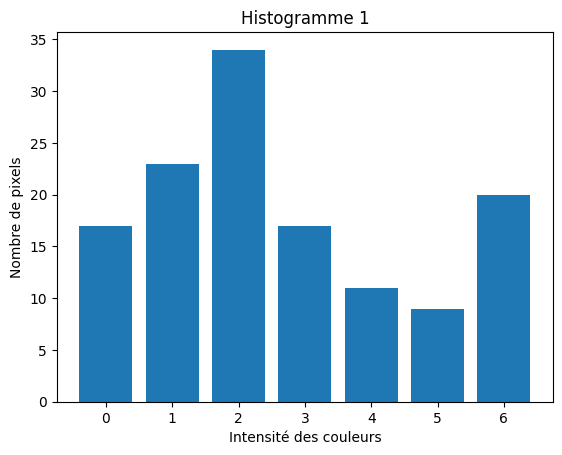

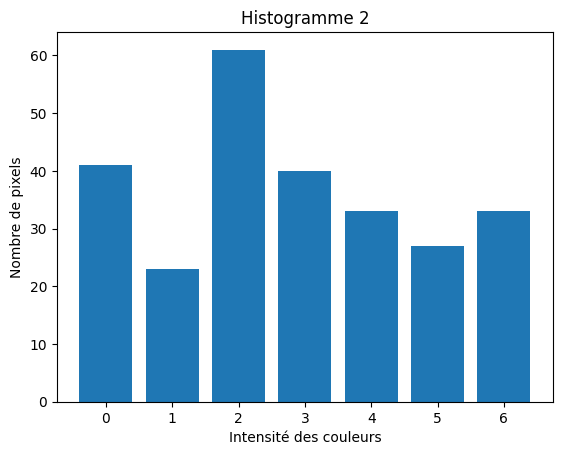

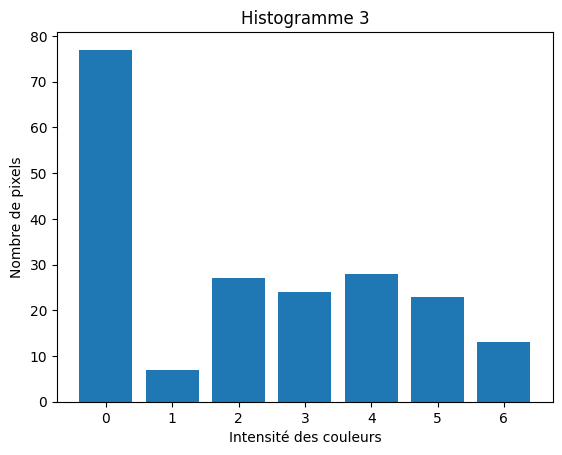

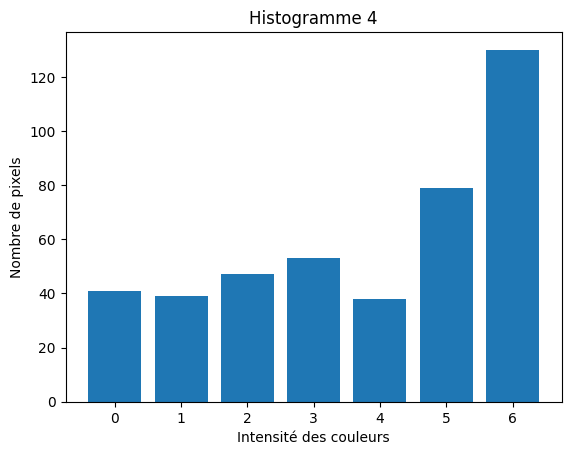

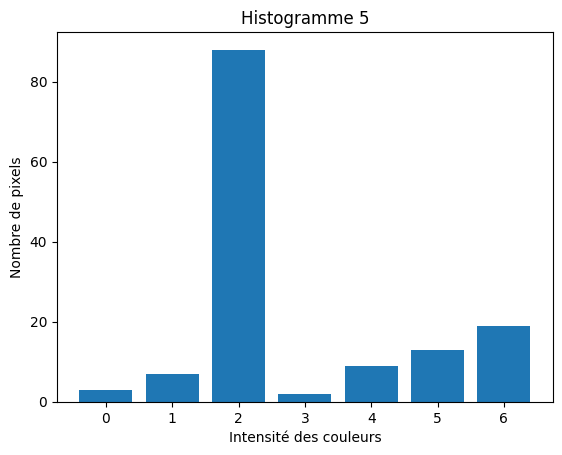

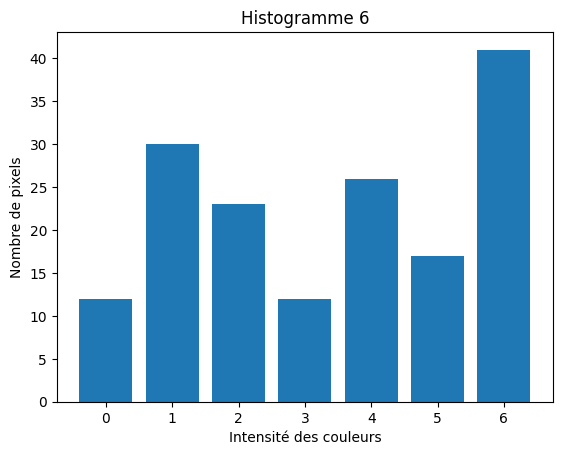

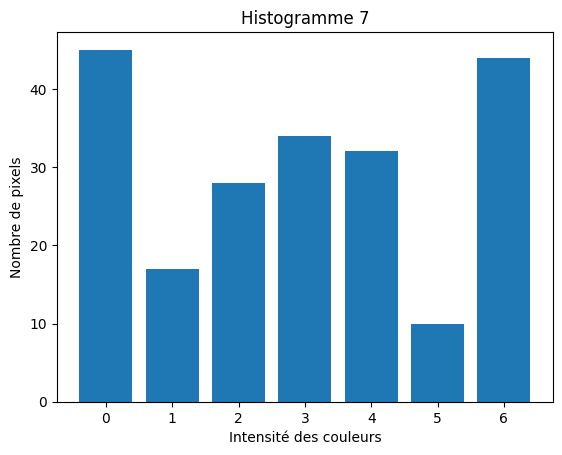

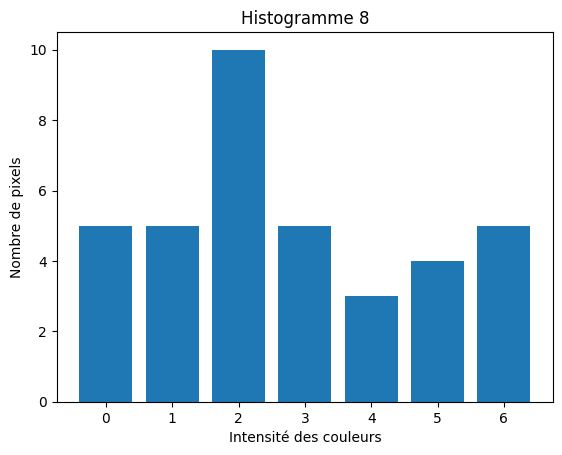

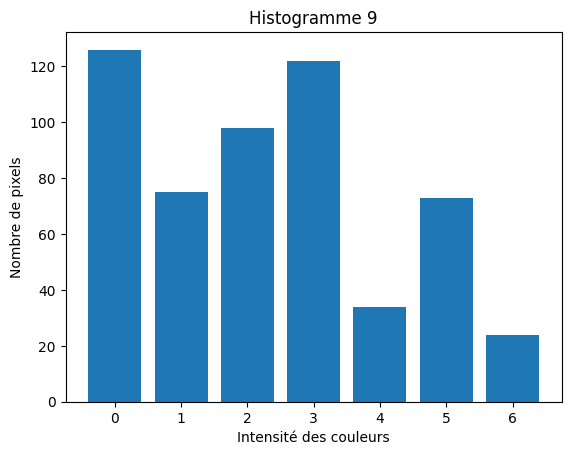

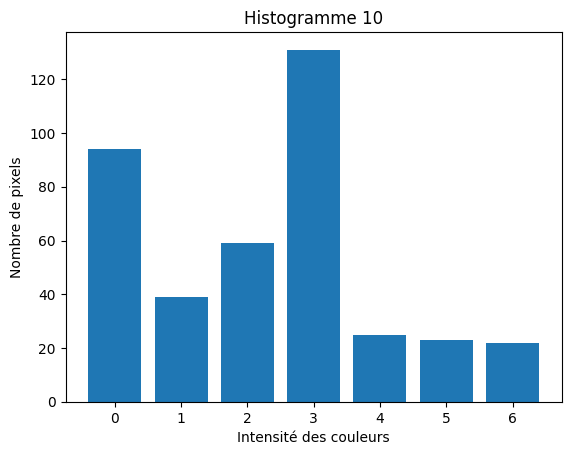

In [ ]:
#Réprésentation des couleurs par nombres de pixels pour les 10 premières images de notre dataset 'train'
for i in range(10):
    plt.bar(range(len(histograms[i])), histograms[i])
    plt.title(f"Histogramme {i+1}")
    plt.xlabel("Intensité des couleurs")
    plt.ylabel("Nombre de pixels")
    plt.show()

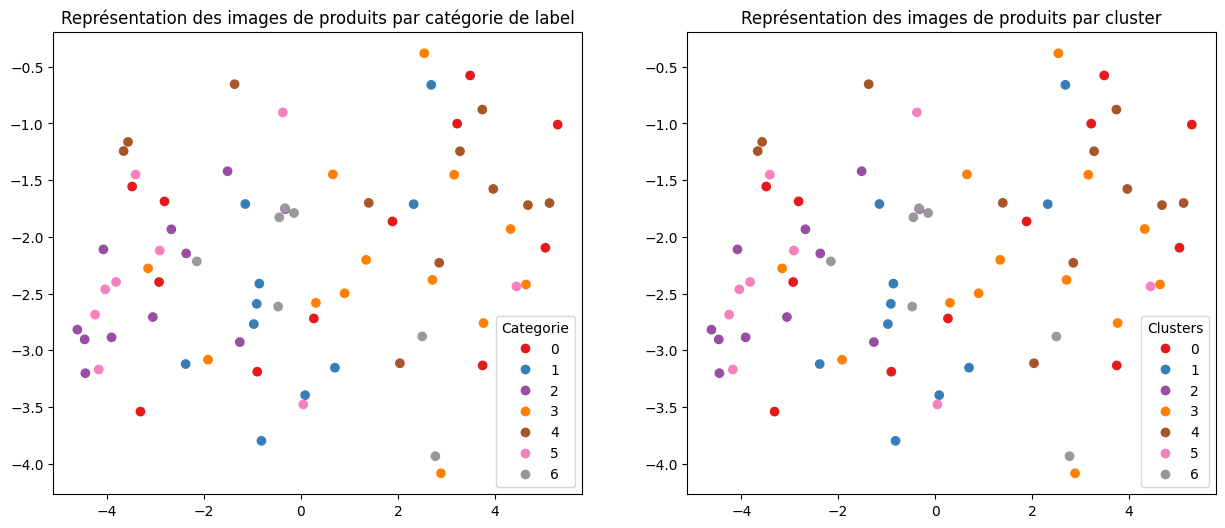

ARI :  0.059469808033943326


In [ ]:
import time
from sklearn import manifold, cluster, metrics

# Fonction pour calculer l'ARI, effectuer la réduction de dimensionnalité et le clustering
def ARI_TSNE_KMeans(features, labels):
    time1 = time.time()
    num_labels = len(set(labels))
    
    # Réduction de dimensionnalité avec t-SNE
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Clustering avec K-means
    kmeans = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    kmeans.fit(X_tsne)
    
    # Calcul de l'indice ARI
    ARI = metrics.adjusted_rand_score(labels, kmeans.labels_)
    time2 = np.round(time.time() - time1, 0)
    
    return ARI, X_tsne, kmeans.labels_

# Fonction pour la visualisation avec t-SNE
def TSNE_visualization(X_tsne, labels, ARI):
    fig = plt.figure(figsize=(15, 6))
    
    # Visualisation selon les vraies catégories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Categorie")
    plt.title('Représentation des images de produits par catégorie de label')
    
    # Visualisation selon les clusters prédits
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des images de produits par cluster')
    
    plt.show()
    print("ARI : ", ARI)

# Utilisation de la fonction ARI_TSNE_KMeans avec les histogrammes
histograms_matrix = np.array(list(histograms.values()))
labels = train_sample['label_enco']

ARI, X_tsne, labels_pred = ARI_TSNE_KMeans(histograms_matrix, labels)
TSNE_visualization(X_tsne, labels, ARI)

**Etape3** = Classification supervisée

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Préparation des données pour l'apprentissage
X_train = np.array(list(histograms.values()))
y_train = train_sample['label'].values

# Entraînement du classifieur KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Chargement des images de test
test_images = []
for img_path in test_sample['image_path']:
    with Image.open(img_path) as img:
        img = img.convert('L') # Conversion en niveaux de gris
        test_images.append(img)

# Création des histogrammes d'images de test
test_histograms = {}
for i, img in enumerate(test_images):
    # Extraction des descripteurs SIFT pour l'image
    kp, des = sift.detectAndCompute(np.array(img), None)
    
    # Attribution de chaque descripteur à un cluster
    labels = kmeans.predict(des)
    
    # Comptage du nombre de descripteurs affectés à chaque cluster
    counts = np.bincount(labels, minlength=kmeans.n_clusters)
    
    # Création de l'histogramme
    test_histograms[i] = counts

# Préparation des données pour la prédiction
X_test = np.array(list(test_histograms.values()))
y_test = test_sample['label'].values

# Prédiction sur les données de test
y_pred = knn.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.09375


In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confusion)

Confusion matrix:
 [[3 0 0 1 0 0 0]
 [1 0 0 2 1 0 0]
 [2 0 0 0 0 0 0]
 [4 0 0 0 0 0 0]
 [5 0 1 1 0 0 0]
 [2 0 0 1 0 0 0]
 [6 0 0 2 0 0 0]]


## Modèle pré-entraîné CNN VGG16

In [ ]:
# Diviser le dataset en train et test
train, test = train_test_split(ecomm_label_image, test_size=0.3, random_state=42)
#stratify=ecomm_label_image['label'] pour garder la même proportion de label dans le train et le test

# Afficher la taille des ensembles de train et test
print("Taille de l'ensemble de train:", len(train))
print("Taille de l'ensemble de test:", len(test))

Taille de l'ensemble de train: 734
Taille de l'ensemble de test: 315


In [ ]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-4].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

modification du paramètre outpout dans modèlspour enlever les 2 dernières couhces

### Création des features des images

In [ ]:
images_features = []
i=0 
for image_file in train["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))#fonction load_img de Keras pour charger les image en taille 224x224pixels
    image = img_to_array(image) #converti en tableau numpy
    image = np.expand_dims(image, axis=0)#ajoute une nouvelle dimension au tableau pour être utilisé comme entrée pour le modèle de deep learning
    image = preprocess_input(image) #tableau normalisé avec cette fonction
    images_features.append(model.predict(image, verbose=0)[0]) # tableau numpy envoyé au model pré-entrainé, sorties stockées dans une liste

images_features = np.asarray(images_features)# liste transformée en tableau numpy
images_features.shape

0
100
200
300
400
500
600
700


(734, 25088)

### Réduction dimension et analyse

In [ ]:
#Create list of label(category)
l_cat = list(set(train['label']))
print("catégories : ", l_cat)

#Variable used for the common function
y_cat_num = [(1-l_cat.index(train.iloc[i]['label'])) for i in range(len(train))]

catégories :  ['Home Furnishing', 'Beauty and Personal Care', 'Home Decor & Festive Needs', 'Watches', 'Baby Care', 'Computers', 'Kitchen & Dining']


In [ ]:
import time

# Pour le calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', random_state=42)
    X_tsne = tsne.fit_transform(features)
# La fonction utilise l'algorithme de réduction de dimensionnalité T-SNE (t-Distributed Stochastic Neighbor Embedding) 
# pour projeter les caractéristiques de chaque document dans un espace de deux dimensions. 
# Cela permet de visualiser les documents dans un espace en deux dimensions, tout en préservant les similitudes entre les documents.

    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    # la fonction utilise l'algorithme de clustering K-means pour regrouper les documents en 
    # un nombre prédéfini de clusters (déterminé par le nombre de classes dans les données originales)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    # la fonction calcule l'indice ARI (adjusted rand index) qui mesure la similarité entre 
    # les vraies étiquettes de classe et les étiquettes de classe prédites par l'algorithme de clustering
    return ARI, X_tsne, cls.labels_



# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    #Représentation des descriptions produits selon les vraies classes. Chaque point = une description et sa position
    # déterminée par sa projection TSNE 2D
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des images de produits par catégorie de label')
    
    #Représentation des descriptions produits selon les clusters prédits. Chaque point = une description et sa position
    # déterminée par sa projection TSNE 2D
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des images de produits par cluster')
    
    plt.show()
    print("ARI : ", ARI)


In [ ]:
#Classification  d'images
print("Images Features : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(images_features)
print()

Images Features : 
-----------------
ARI :  0.2811 time :  13.0



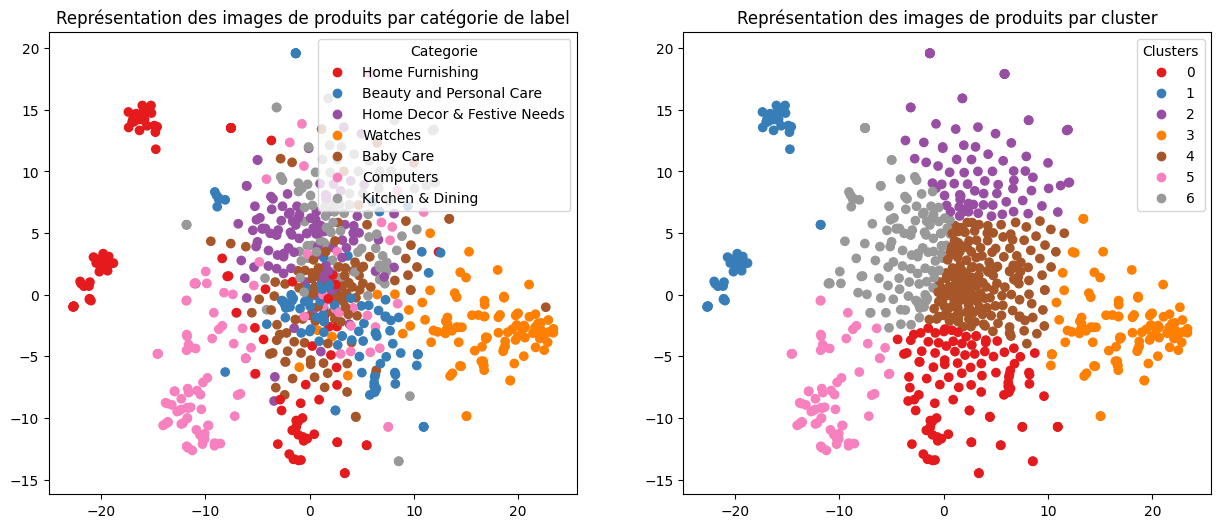

ARI :  0.2811


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

***ACP vs TSNE***

*Avantages de l'ACP :*

- L'ACP est une technique de réduction de dimensions linéaire (relation proportionnelles des variables entre elles) qui permet de détecter les relations linéaires entre les variables d'un ensemble de données.
- L'ACP est facile à interpréter et peut être utilisée pour visualiser les données sous forme de graphique en deux dimensions.
- L'ACP est rapide et peut être appliquée sur des ensembles de données de grande taille.

*Inconvénients de l'ACP :*

- L'ACP est sensible aux valeurs aberrantes et aux données manquantes, ce qui peut affecter les résultats de la RD.
- L'ACP ne peut pas capturer les relations non linéaires entre les variables.


*Avantages de t-SNE :*

- Le t-SNE est une technique de RD non linéaire ( qui permet de capturer les relations non linéaires entre les variables d'un ensemble de données.
- Le t-SNE est robuste aux valeurs aberrantes et aux données manquantes.
- Le t-SNE peut être utilisé pour visualiser des ensembles de données complexes sous forme de graphique en deux dimensions.


*Inconvénients de t-SNE*

- Le t-SNE est plus lent que l'ACP et peut être difficile à appliquer sur des ensembles de données de grande taille.
- Le t-SNE est plus difficile à interpréter que l'ACP en raison de sa complexité mathématique. 

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

the list is 2
3


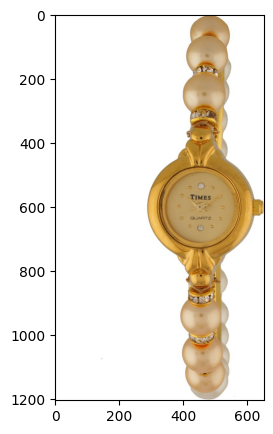

In [ ]:
# Analyse d'image "Watches" affectées au cluster 4 "Baby care"

list_beauty_0 = [i for i in range(len(train["image_path"])) \
                if (train.iloc[i]['label']=='Watches') and (cls.labels_== 4).any()]
print('the list is',list_beauty_0[0])

# Affichage image "Watches" considérée comme "Baby Care"
id = list_beauty_0[0]
print(cls.labels_[id])
fig = plt.figure(figsize = (8, 5))

# plt.subplot(130 + 1 + i)
filename = train["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()



Cette montre est considéré comme un produit 'baby care' - peut être que les caractéristiques de couleurs et de perles rappelle la catégorie Baby. 

### Analyse par classes

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

In [ ]:
#matrice de confusion entre les étiquettes réelles des images (stockées dans la variable "labels") 
#et les étiquettes prédites pour ces images (stockées dans la variable "cls.labels_").
labels = train['label_enco'] #utilisation des labels encodés, la matrice de confusion ne prend que des chiffres
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[27  4 59  0  0  1 14]
 [16  6 12  0  0 67 10]
 [37 32 16  7  0  1  9]
 [54 27 13  3  0  0  7]
 [34  3 13  0  3  0 47]
 [ 6 32 12  1 59  1  1]
 [ 6  4  0 90  0  0  0]]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0) # recherche la correspondance des clusters en utilisant la fonction "argmax" de numpy 
    #pour trouver l'indice du cluster le plus représentatif pour chaque classe
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame() #DataFrame pandas appelé "labels", qui contient les étiquettes réelles et prédites, ainsi qu'une nouvelle colonne "y_pred_transform", 
    #qui contient les nouvelles étiquettes prédites pour chaque image.
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [ ]:
#rapport de classification fournit des informations sur les performances du modèle pour chaque classe
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3 2 0 6 5 1 4]
[[59  1  4 27 14  0  0]
 [12 67  6 16 10  0  0]
 [16  1 32 37  9  0  7]
 [13  0 27 54  7  0  3]
 [13  0  3 34 47  3  0]
 [12  1 32  6  1 59  1]
 [ 0  0  4  6  0  0 90]]

              precision    recall  f1-score   support

           0       0.47      0.56      0.51       105
           1       0.96      0.60      0.74       111
           2       0.30      0.31      0.30       102
           3       0.30      0.52      0.38       104
           4       0.53      0.47      0.50       100
           5       0.95      0.53      0.68       112
           6       0.89      0.90      0.90       100

    accuracy                           0.56       734
   macro avg       0.63      0.56      0.57       734
weighted avg       0.64      0.56      0.58       734



<Axes: >

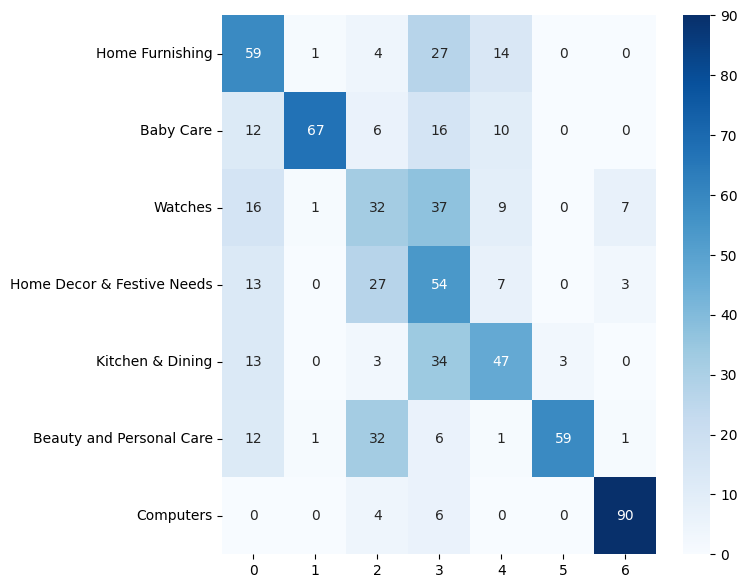

In [ ]:
#Créer un DataFrame "df_cm" à partir de la matrice de confusion "conf_mat". Le DataFrame a des labels de rangée définis 
#par les éléments uniques de la liste "list_labels", qui contient les noms des classes de l'ensemble de données. 
#Les noms des colonnes sont définis manuellement en tant que "0", "1", "2" et "3".
#Représentation visuelle de la matrice de confusion qui permet de visualiser 
#facilement les performances de chaque classe de l'ensemble de données.
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")

la classe la moins bien prédite est Watches - les caractéristiques d'une montre semblent se confondre avec d'autres catégories

## Modèle pré entrainé CNN : EfficientNetB7

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
# Diviser le dataset en train et test
train, test = train_test_split(ecomm_label_image, test_size=0.3, random_state=42)

# Afficher la taille des ensembles de train et test
print("Taille de l'ensemble de train:", len(train))
print("Taille de l'ensemble de test:", len(test))

Taille de l'ensemble de train: 734
Taille de l'ensemble de test: 315


In [ ]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_9 (Rescaling)        (None, 260, 260, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization_4 (Normalization  (None, 260, 260, 3)  7          ['rescaling_9[0][0]']            
 )                                                                                                
                                                                                            

### Création des features des images

In [ ]:
images_features = []
i=0 
for image_file in train["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(260, 260))#fonction load_img de Keras pour charger les image en taille 224x224pixels
    image = img_to_array(image) #converti en tableau numpy
    image = np.expand_dims(image, axis=0)#ajoute une nouvelle dimension au tableau pour être utilisé comme entrée pour le modèle de deep learning
    image = preprocess_input(image) #tableau normalisé avec cette fonction
    image_features = model.predict(image, verbose=0)[0]
    image_features_flattened = image_features.flatten()  # Aplatir les dimensions spatiales
    images_features.append(image_features_flattened)

images_features = np.asarray(images_features)
print(images_features.shape)
#     images_features.append(model.predict(image, verbose=0)[0]) # tableau numpy envoyé au model pré-entrainé, sorties stockées dans une liste

# images_features = np.asarray(images_features)# liste transformée en tableau numpy
# images_features.shape

0
100
200
300
400
500
600
700
(734, 114048)


### Réduction dimension et analyse

In [ ]:
#Create list of label(category)
l_cat = list(set(train['label']))
print("catégories : ", l_cat)

#Variable used for the common function
y_cat_num = [(1-l_cat.index(train.iloc[i]['label'])) for i in range(len(train))]

catégories :  ['Home Furnishing', 'Beauty and Personal Care', 'Home Decor & Festive Needs', 'Watches', 'Baby Care', 'Computers', 'Kitchen & Dining']


In [ ]:
import time

# Pour le calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', random_state=42)
    X_tsne = tsne.fit_transform(features)
# La fonction utilise l'algorithme de réduction de dimensionnalité T-SNE (t-Distributed Stochastic Neighbor Embedding) 
# pour projeter les caractéristiques de chaque document dans un espace de deux dimensions. 
# Cela permet de visualiser les documents dans un espace en deux dimensions, tout en préservant les similitudes entre les documents.

    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    # la fonction utilise l'algorithme de clustering K-means pour regrouper les documents en 
    # un nombre prédéfini de clusters (déterminé par le nombre de classes dans les données originales)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    # la fonction calcule l'indice ARI (adjusted rand index) qui mesure la similarité entre 
    # les vraies étiquettes de classe et les étiquettes de classe prédites par l'algorithme de clustering
    return ARI, X_tsne, cls.labels_



# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    #Représentation des descriptions produits selon les vraies classes. Chaque point = une description et sa position
    # déterminée par sa projection TSNE 2D
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des images de produits par catégorie de label')
    
    #Représentation des descriptions produits selon les clusters prédits. Chaque point = une description et sa position
    # déterminée par sa projection TSNE 2D
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des images de produits par cluster')
    
    plt.show()
    print("ARI : ", ARI)


In [ ]:
images_features.shape

(734, 114048)

In [ ]:
#Classification  d'images
print("Images Features : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(images_features)
print()

Images Features : 
-----------------
ARI :  0.3738 time :  36.0



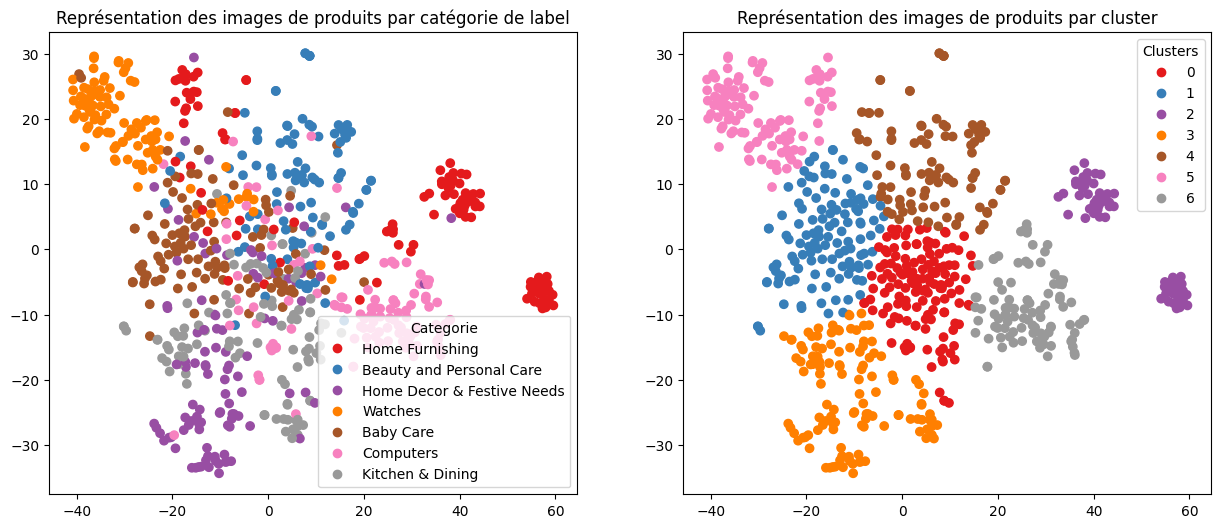

ARI :  0.3738


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

***ACP vs TSNE***

*Avantages de l'ACP :*

- L'ACP est une technique de réduction de dimensions linéaire (relation proportionnelles des variables entre elles) qui permet de détecter les relations linéaires entre les variables d'un ensemble de données.
- L'ACP est facile à interpréter et peut être utilisée pour visualiser les données sous forme de graphique en deux dimensions.
- L'ACP est rapide et peut être appliquée sur des ensembles de données de grande taille.

*Inconvénients de l'ACP :*

- L'ACP est sensible aux valeurs aberrantes et aux données manquantes, ce qui peut affecter les résultats de la RD.
- L'ACP ne peut pas capturer les relations non linéaires entre les variables.


*Avantages de t-SNE :*

- Le t-SNE est une technique de RD non linéaire ( qui permet de capturer les relations non linéaires entre les variables d'un ensemble de données.
- Le t-SNE est robuste aux valeurs aberrantes et aux données manquantes.
- Le t-SNE peut être utilisé pour visualiser des ensembles de données complexes sous forme de graphique en deux dimensions.


*Inconvénients de t-SNE*

- Le t-SNE est plus lent que l'ACP et peut être difficile à appliquer sur des ensembles de données de grande taille.
- Le t-SNE est plus difficile à interpréter que l'ACP en raison de sa complexité mathématique. 

la longueur de cette liste est de 112
le premier élément de la liste est à l"index 1
la classe kmeans attribuée à cette image est 6


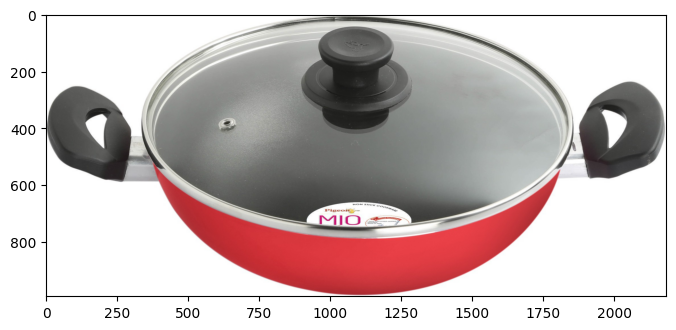

In [ ]:
# Analyse d'image "Kitchen & Dining" affectées au cluster 0 "Home Furniture"

list_0 = [i for i in range(len(train["image_path"])) \
                if (train.iloc[i]['label']=='Kitchen & Dining') and (cls.labels_==0).any()]
print('la longueur de cette liste est de',len(list_0))
print('le premier élément de la liste est à l"index',list_0[0])

# Affichage image "Kitchen and Dining" considérée comme "HOme furniture"
id = list_0[0]
print('la classe kmeans attribuée à cette image est',cls.labels_[id])
fig = plt.figure(figsize = (8, 5))

# plt.subplot(130 + 1 + i)
filename = train["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()



Les caractéristiques du Home Furniture semblent se confondrent avec celle de "Kitchen & Dining"

### Analyse par classes

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

In [ ]:
#matrice de confusion entre les étiquettes réelles des images (stockées dans la variable "labels") 
#et les étiquettes prédites pour ces images (stockées dans la variable "cls.labels_").
labels = train['label_enco'] #utilisation des labels encodés, la matrice de confusion ne prend que des chiffres
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[67 18  1  2 14  1  2]
 [ 6 21 72  1  4  0  7]
 [ 1 22  1  1  8  0 69]
 [ 1 26  1  3 67  0  6]
 [44 42  1  0 11  0  2]
 [ 0  6 13 19  8 58  8]
 [ 0  2  0 84 10  0  4]]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0) # recherche la correspondance des clusters en utilisant la fonction "argmax" de numpy 
    #pour trouver l'indice du cluster le plus représentatif pour chaque classe
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame() #DataFrame pandas appelé "labels", qui contient les étiquettes réelles et prédites, ainsi qu'une nouvelle colonne "y_pred_transform", 
    #qui contient les nouvelles étiquettes prédites pour chaque image.
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [ ]:
#rapport de classification fournit des informations sur les performances du modèle pour chaque classe
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0 4 1 6 3 5 2]
[[67  1  2 14 18  1  2]
 [ 6 72  7  4 21  0  1]
 [ 1  1 69  8 22  0  1]
 [ 1  1  6 67 26  0  3]
 [44  1  2 11 42  0  0]
 [ 0 13  8  8  6 58 19]
 [ 0  0  4 10  2  0 84]]

              precision    recall  f1-score   support

           0       0.56      0.64      0.60       105
           1       0.81      0.65      0.72       111
           2       0.70      0.68      0.69       102
           3       0.55      0.64      0.59       104
           4       0.31      0.42      0.35       100
           5       0.98      0.52      0.68       112
           6       0.76      0.84      0.80       100

    accuracy                           0.63       734
   macro avg       0.67      0.63      0.63       734
weighted avg       0.67      0.63      0.64       734



<Axes: >

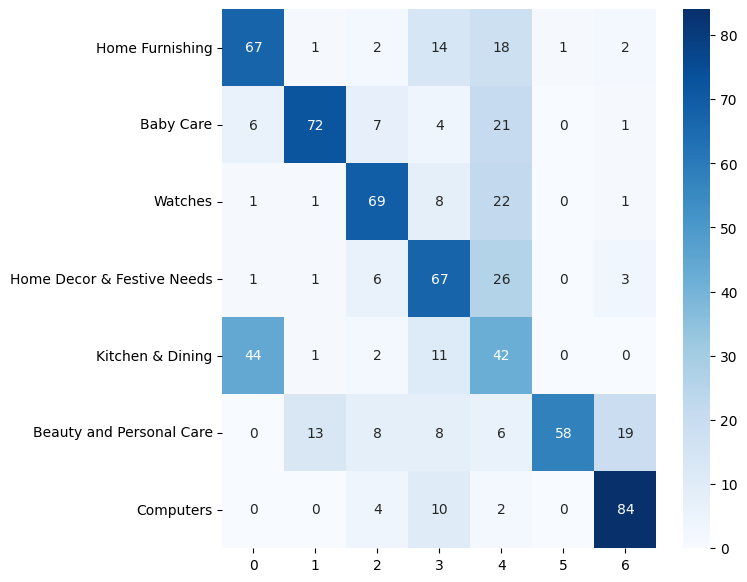

In [ ]:
#Créer un DataFrame "df_cm" à partir de la matrice de confusion "conf_mat". Le DataFrame a des labels de rangée définis 
#par les éléments uniques de la liste "list_labels", qui contient les noms des classes de l'ensemble de données. 
#Les noms des colonnes sont définis manuellement en tant que "0", "1", "2" et "3".
#Représentation visuelle de la matrice de confusion qui permet de visualiser 
#facilement les performances de chaque classe de l'ensemble de données.
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")

la classe la moins bien prédite est Kitchen & Dining - ce qui confirme l'analyse d'image faite précedemment.

# **Etape 2 : classification supervisée**
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [ ]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [ ]:
#Creation d'un dataframe pour comparer les résultats (accuracy et temps) 
results_models = []

In [ ]:
best_val_accuracy = 0.0
best_test_accuracy = 0.0


## Approche préparation initiale des images

In [ ]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(train)
print(images_np.shape)
images_np_test = image_prep_fct(test)
print(images_np_test.shape)

(734, 224, 224, 3)
(315, 224, 224, 3)


In [ ]:
X = images_np
y = to_categorical(train['label_enco'])

X_test = images_np_test
y_test = to_categorical(test['label_enco'])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(550, 224, 224, 3)

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=10, batch_size=30, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 5.5867 - accuracy: 0.4582
Epoch 1: val_loss improved from inf to 2.06600, saving model to .\model1_best_weights.h5
19/19 [==============================] - 234s 12s/step - loss: 5.5867 - accuracy: 0.4582 - val_loss: 2.0660 - val_accuracy: 0.6630
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 2.0600 - accuracy: 0.6800
Epoch 2: val_loss improved from 2.06600 to 1.15957, saving model to .\model1_best_weights.h5
19/19 [==============================] - 244s 13s/step - loss: 2.0600 - accuracy: 0.6800 - val_loss: 1.1596 - val_accuracy: 0.7500
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 1.1669 - accuracy: 0.7673
Epoch 3: val_loss improved from 1.15957 to 1.09911, saving model to .\model1_best_weights.h5
19/19 [==============================] - 231s 12s/step - loss: 1.1669 - accuracy: 0.7673 - val_loss: 1.0991 - val_accuracy: 0.7826
Epoch 4/10
19/19 [==============================] 

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


(550, 224, 224, 3)
(550, 7)
(184, 224, 224, 3)
(184, 7)


In [ ]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

18/18 [==============================] - 190s 11s/step - loss: 0.0320 - accuracy: 0.9909
Training Accuracy: 0.9909

6/6 [==============================] - 67s 11s/step - loss: 1.2095 - accuracy: 0.7717
Validation Accuracy:  0.7717


In [ ]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

start_time = time.time()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
if accuracy > best_val_accuracy:
    best_val_accuracy = accuracy
end_time = time.time()
validation_time = end_time - start_time
print("Validation Accuracy :  {:.4f}".format(accuracy))

start_time = time.time()
loss, accuracy = model1.evaluate(X_test, y_test, verbose=True)
if accuracy > best_test_accuracy:
    best_test_accuracy = accuracy
    end_time = time.time()
test_time = end_time - start_time
print("Test Accuracy       :  {:.4f}".format(accuracy))


6/6 [==============================] - 92s 15s/step - loss: 0.9471 - accuracy: 0.8098
Validation Accuracy :  0.8098
10/10 [==============================] - 157s 15s/step - loss: 1.2368 - accuracy: 0.7968
Test Accuracy       :  0.7968


In [ ]:
results_models.append({'Modèle': 'Modèle 1_approche initiale', 'Accuracy (Validation)': best_val_accuracy, 'Temps (Validation)': validation_time, 'Accuracy (Test)': best_test_accuracy, 'Temps (Test)': test_time})

In [ ]:
results_models

[{'Modèle': 'Modèle 1_approche initiale',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 92.3617742061615,
  'Accuracy (Test)': 0.7968254089355469,
  'Temps (Test)': 157.20491456985474}]

In [ ]:
#LEGER SUR APPRENTISSAGE vgg16 est ancien comme modèle, peu d'images 

In [ ]:
pip install plot_keras_history

Note: you may need to restart the kernel to use updated packages.


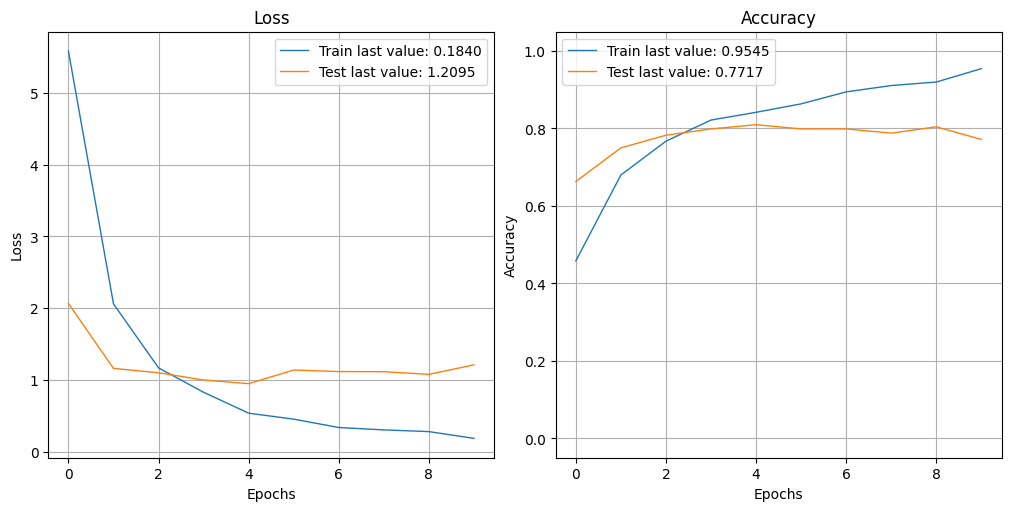

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [ ]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

6/6 [==============================] - 72s 12s/step
[1 2 2 3 4 6 1 3 3 5 4 1 1 3 3 1 0 0 0 1 4 5 3 0 6 1 6 6 5 4 0 2 0 4 1 3 3
 5 1 6 2 5 4 0 5 1 0 2 0 4 4 6 4 6 6 6 5 4 0 5 1 3 4 6 1 1 2 6 1 3 5 2 1 3
 3 5 1 3 6 0 2 5 6 5 2 0 1 5 4 3 6 1 2 3 3 4 2 4 2 4 0 0 3 6 2 5 4 4 0 0 4
 1 1 0 3 5 0 2 2 1 0 6 6 0 5 0 5 1 5 2 4 2 4 5 1 0 6 0 1 5 4 5 0 2 2 3 4 2
 6 5 5 3 5 3 0 1 4 4 5 3 2 5 1 6 6 3 6 5 6 6 2 2 2 4 2 1 3 6 2 3 3 0 5 1]

[1 2 2 3 4 6 1 1 3 5 4 1 1 3 6 1 0 3 4 6 4 5 3 0 6 1 6 6 5 4 0 2 4 0 1 0 3
 5 1 6 2 5 4 4 5 1 0 2 0 4 4 6 0 1 6 6 5 4 0 5 1 3 4 6 1 5 2 6 1 3 5 2 3 0
 5 5 1 1 6 0 2 5 6 5 2 3 5 5 4 6 6 1 3 2 3 4 5 4 2 4 4 1 3 6 2 3 0 4 0 0 4
 1 5 6 3 5 0 2 2 1 0 6 6 0 5 0 5 1 1 2 4 0 0 5 1 0 6 5 1 5 4 5 0 2 1 3 4 2
 6 5 5 3 5 3 0 1 4 4 5 3 2 5 1 6 6 3 6 2 3 6 2 2 2 4 2 1 3 6 2 3 3 0 5 1]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [ ]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[17  1  0  2  4  1  1]
 [ 0 23  0  1  0  3  1]
 [ 1  1 22  1  0  1  0]
 [ 2  2  1 18  0  1  2]
 [ 4  0  0  0 21  0  0]
 [ 0  1  1  1  0 25  0]
 [ 0  1  0  1  0  0 23]]


In [ ]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[17  1  0  2  4  1  1]
 [ 0 23  0  1  0  3  1]
 [ 1  1 22  1  0  1  0]
 [ 2  2  1 18  0  1  2]
 [ 4  0  0  0 21  0  0]
 [ 0  1  1  1  0 25  0]
 [ 0  1  0  1  0  0 23]]

              precision    recall  f1-score   support

           0       0.71      0.65      0.68        26
           1       0.79      0.82      0.81        28
           2       0.92      0.85      0.88        26
           3       0.75      0.69      0.72        26
           4       0.84      0.84      0.84        25
           5       0.81      0.89      0.85        28
           6       0.85      0.92      0.88        25

    accuracy                           0.81       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.81      0.81      0.81       184



<Axes: >

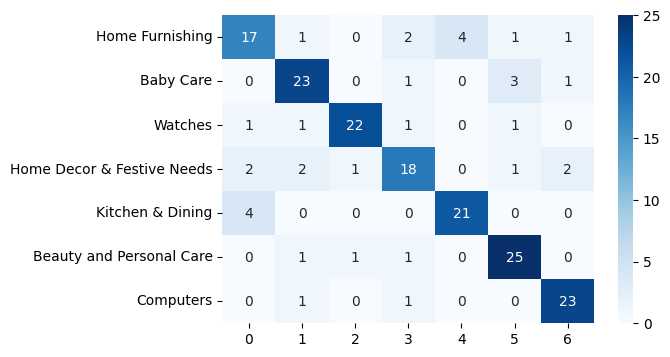

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

classification moyenne pour toutes les classes

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Pour mélanger les images, classées initalement par classe
data = ecomm_label_image.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [ ]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 787 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 315 validated image filenames belonging to 7 classes.


In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)


Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 4.0061 - accuracy: 0.4295 
Epoch 1: val_loss improved from inf to 1.25080, saving model to .\model2_best_weights.h5
25/25 [==============================] - 461s 18s/step - loss: 4.0061 - accuracy: 0.4295 - val_loss: 1.2508 - val_accuracy: 0.6985
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 1.4759 - accuracy: 0.6684 
Epoch 2: val_loss improved from 1.25080 to 1.09108, saving model to .\model2_best_weights.h5
25/25 [==============================] - 441s 18s/step - loss: 1.4759 - accuracy: 0.6684 - val_loss: 1.0911 - val_accuracy: 0.7519
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 1.0263 - accuracy: 0.7446 
Epoch 3: val_loss improved from 1.09108 to 0.85824, saving model to .\model2_best_weights.h5
25/25 [==============================] - 463s 19s/step - loss: 1.0263 - accuracy: 0.7446 - val_loss: 0.8582 - val_accuracy: 0.7939
Epoch 4/20
25/25 [=============================

In [ ]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 360s 14s/step - loss: 0.1192 - accuracy: 0.9657
Training Accuracy   : 0.9657

9/9 [==============================] - 122s 13s/step - loss: 0.9643 - accuracy: 0.8053
Validation Accuracy :  0.8053


In [ ]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

start_time = time.time()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
if accuracy > best_val_accuracy:
    best_val_accuracy = accuracy
end_time = time.time()
validation_time = end_time - start_time
print("Validation Accuracy :  {:.4f}".format(accuracy))

start_time = time.time()
loss, accuracy = model2.evaluate(test_flow, verbose=True)
if accuracy > best_test_accuracy:
    best_test_accuracy = accuracy
end_time = time.time()
test_time = end_time - start_time
print("Test Accuracy       :  {:.4f}".format(accuracy))


9/9 [==============================] - 179s 19s/step - loss: 0.8370 - accuracy: 0.7939
Validation Accuracy :  0.7939
10/10 [==============================] - 211s 21s/step - loss: 0.8471 - accuracy: 0.8317
Test Accuracy       :  0.8317


In [ ]:
results_models.append({'Modèle': 'Modèle 2_datagnerator', 'Accuracy (Validation)': best_val_accuracy, 'Temps (Validation)': validation_time, 'Accuracy (Test)': best_test_accuracy, 'Temps (Test)': test_time})

In [ ]:
results_models

[{'Modèle': 'Modèle 1_approche initiale',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 92.3617742061615,
  'Accuracy (Test)': 0.7968254089355469,
  'Temps (Test)': 157.20491456985474},
 {'Modèle': 'Modèle 2_datagnerator',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 181.0542333126068,
  'Accuracy (Test)': 0.8317460417747498,
  'Temps (Test)': 211.6145408153534}]

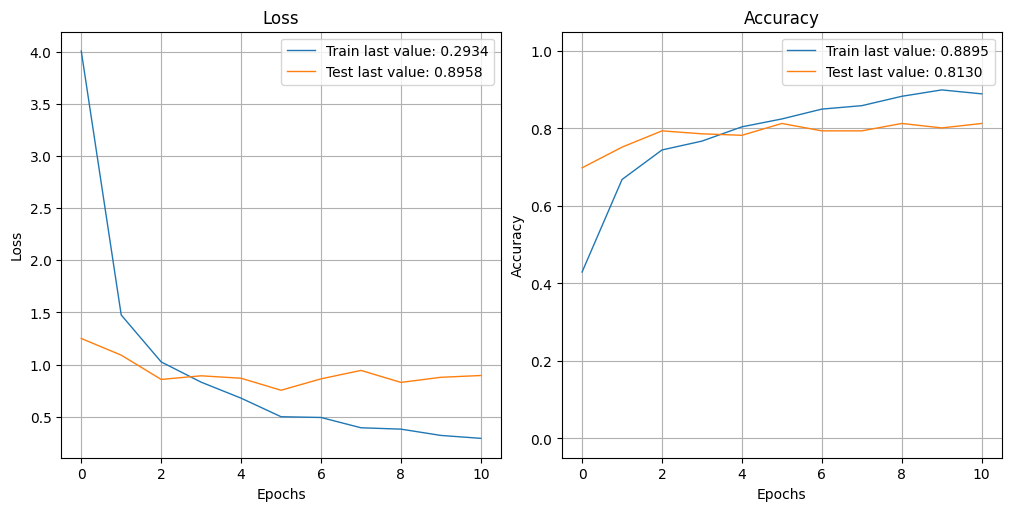

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
path_new =r"C:\Users\dalila.derdar.ONCEFORALL\OneDrive\OneDrive - ALG\Bureau\Projet 6 VS Studio\Images"

In [ ]:
#dispatch des images dans deux dossier train and test avec chacun 7 sous dossiers correspondant au 7 labels, pour que la fonction tf.keras.utils.image_dataset_from_directory puisse les lire

import os
import shutil
from sklearn.model_selection import train_test_split

# Étape 1 : Faire un train test split pour obtenir les index des sets train et test
# Supposons que vous avez une liste d'images appelée "images" et une liste de labels appelée "labels"
train_images, test_images = train_test_split(ecomm_label_image, test_size=0.2, random_state=42)

# Étape 2 : Créer les dossiers "train" et "test"
train_dir = os.path.join(path_new, "train")
test_dir = os.path.join(path_new, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Étape 3 : Créer les sous-dossiers pour chaque classe
categories = train_images['label'].unique()

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Étape 4 : Copier les images dans les dossiers respectifs
def copy_images(data, source_dir, dest_dir):
    for _, row in data.iterrows():
        image_path = row['image_path']  
        category = row['label']  
        category_folder = os.path.join(dest_dir, category)
        os.makedirs(category_folder, exist_ok=True)
        image_filename = os.path.basename(image_path)
        shutil.copy(image_path, os.path.join(category_folder, image_filename))

copy_images(train_images, path_new, train_dir)
copy_images(test_images, path_new, test_dir)

In [ ]:
path =r"C:\Users\dalila.derdar.ONCEFORALL\OneDrive\OneDrive - ALG\Bureau\Projet 6 VS Studio\Images\test"
path_test =r"C:\Users\dalila.derdar.ONCEFORALL\OneDrive\OneDrive - ALG\Bureau\Projet 6 VS Studio\Images\train"

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type, follow_links=True
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 210 files belonging to 7 classes.
Using 158 files for training.
Found 210 files belonging to 7 classes.
Using 52 files for validation.
Found 839 files belonging to 7 classes.


In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)


Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 12.5683 - accuracy: 0.2468 
Epoch 1: val_loss improved from inf to 5.46871, saving model to .\model3_best_weights.h5
5/5 [==============================] - 71s 14s/step - loss: 12.5683 - accuracy: 0.2468 - val_loss: 5.4687 - val_accuracy: 0.4038
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 4.0445 - accuracy: 0.5759
Epoch 2: val_loss improved from 5.46871 to 3.89484, saving model to .\model3_best_weights.h5
5/5 [==============================] - 67s 14s/step - loss: 4.0445 - accuracy: 0.5759 - val_loss: 3.8948 - val_accuracy: 0.5385
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 2.2862 - accuracy: 0.7025
Epoch 3: val_loss improved from 3.89484 to 3.27554, saving model to .\model3_best_weights.h5
5/5 [==============================] - 66s 14s/step - loss: 2.2862 - accuracy: 0.7025 - val_loss: 3.2755 - val_accuracy: 0.5577
Epoch 4/20
5/5 [==============================] - ETA: 0s - lo

In [ ]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 [==============================] - 53s 10s/step - loss: 0.0028 - accuracy: 1.0000
Training Accuracy   : 1.0000

2/2 [==============================] - 17s 7s/step - loss: 3.3343 - accuracy: 0.6538
Validation Accuracy :  0.6538


In [ ]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

start_time = time.time()
loss, accuracy = model3.evaluate(dataset_val, verbose=False)
if accuracy > best_val_accuracy:
    best_val_accuracy = accuracy
end_time = time.time()
validation_time = end_time - start_time
print("Validation Accuracy :  {:.4f}".format(accuracy))

start_time = time.time()
loss, accuracy = model3.evaluate(dataset_test, verbose=False)
if accuracy > best_test_accuracy:
    best_test_accuracy = accuracy
end_time = time.time()
test_time = end_time - start_time
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.6538
Test Accuracy       :  0.7390


In [ ]:
del(results_models[-1])

In [ ]:
results_models.append({'Modèle': 'Modèle 3_dataset', 'Accuracy (Validation)': best_val_accuracy, 'Temps (Validation)': validation_time, 'Accuracy (Test)': best_test_accuracy, 'Temps (Test)': test_time})

In [ ]:
results_models

[{'Modèle': 'Modèle 1_approche initiale',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 92.3617742061615,
  'Accuracy (Test)': 0.7968254089355469,
  'Temps (Test)': 157.20491456985474},
 {'Modèle': 'Modèle 2_datagnerator',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 181.0542333126068,
  'Accuracy (Test)': 0.8317460417747498,
  'Temps (Test)': 211.6145408153534},
 {'Modèle': 'Modèle 3_dataset',
  'Accuracy (Validation)': 0.7389749884605408,
  'Temps (Validation)': 27.607942819595337,
  'Accuracy (Test)': 0.7389749884605408,
  'Temps (Test)': 417.2826871871948}]

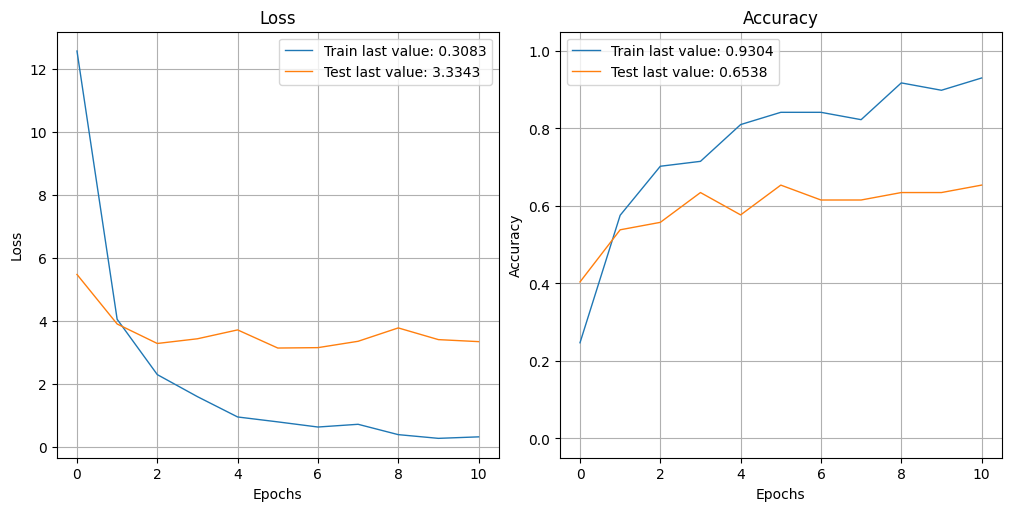

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 210 files belonging to 7 classes.
Using 158 files for training.
Found 210 files belonging to 7 classes.
Using 52 files for validation.
Found 839 files belonging to 7 classes.


In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image = (image / 255.0)
    return image, label



In [ ]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)


Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 2.0035 - accuracy: 0.2089 
Epoch 1: val_loss improved from inf to 1.74693, saving model to .\model4_best_weights.h5
5/5 [==============================] - 75s 15s/step - loss: 2.0035 - accuracy: 0.2089 - val_loss: 1.7469 - val_accuracy: 0.3077
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 1.7357 - accuracy: 0.3354
Epoch 2: val_loss improved from 1.74693 to 1.59646, saving model to .\model4_best_weights.h5
5/5 [==============================] - 67s 14s/step - loss: 1.7357 - accuracy: 0.3354 - val_loss: 1.5965 - val_accuracy: 0.5192
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 1.6397 - accuracy: 0.4494 
Epoch 3: val_loss improved from 1.59646 to 1.44332, saving model to .\model4_best_weights.h5
5/5 [==============================] - 68s 14s/step - loss: 1.6397 - accuracy: 0.4494 - val_loss: 1.4433 - val_accuracy: 0.6538
Epoch 4/20
5/5 [==============================] - ETA: 0s - los

In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

5/5 [==============================] - 51s 10s/step - loss: 0.4081 - accuracy: 0.8861
Training Accuracy   : 0.8861

2/2 [==============================] - 16s 6s/step - loss: 0.9070 - accuracy: 0.7308
Validation Accuracy :  0.7308


In [ ]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

start_time = time.time()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
if accuracy > best_val_accuracy:
    best_val_accuracy = accuracy
print("Validation Accuracy :  {:.4f}".format(accuracy))
end_time = time.time()
validation_time = end_time - start_time

start_time = time.time()
loss, accuracy = model4.evaluate(dataset_test, verbose=True)
if accuracy > best_test_accuracy:
    best_test_accuracy = accuracy
end_time = time.time()
test_time = end_time - start_time
print("Test Accuracy       :  {:.4f}".format(accuracy))


2/2 [==============================] - 59s 18s/step - loss: 0.9070 - accuracy: 0.7308
Validation Accuracy :  0.7308
27/27 [==============================] - 488s 18s/step - loss: 0.8311 - accuracy: 0.7473
Test Accuracy       :  0.7473


In [ ]:
results_models.append({'Modèle': 'Modèle 4_DataAugmentation_intégré', 'Accuracy (Validation)': best_val_accuracy, 'Temps (Validation)': validation_time, 'Accuracy (Test)': best_test_accuracy, 'Temps (Test)': test_time})

In [ ]:
results_models

[{'Modèle': 'Modèle 1_approche initiale',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 92.3617742061615,
  'Accuracy (Test)': 0.7968254089355469,
  'Temps (Test)': 157.20491456985474},
 {'Modèle': 'Modèle 2_datagnerator',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 181.0542333126068,
  'Accuracy (Test)': 0.8317460417747498,
  'Temps (Test)': 211.6145408153534},
 {'Modèle': 'Modèle 3_dataset',
  'Accuracy (Validation)': 0.7389749884605408,
  'Temps (Validation)': 27.607942819595337,
  'Accuracy (Test)': 0.7389749884605408,
  'Temps (Test)': 417.2826871871948},
 {'Modèle': 'Modèle 4_DataAugmentation_intégré',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 59.24587345123291,
  'Accuracy (Test)': 0.8317460417747498,
  'Temps (Test)': 487.69618225097656}]

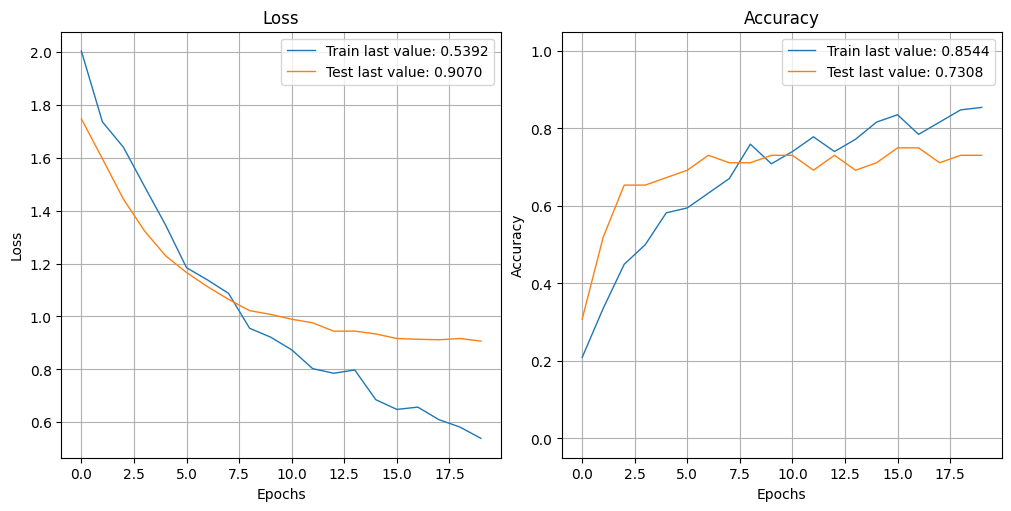

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

# **Approche avec data augmentation et Efficientnetb2**

In [ ]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    #model0 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model0 = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    #possibilité de changer d'optimizer : adam, rmsprop, sgd, adagrad, adadelta, adamax, nadam, ftlr. Possibilité de prendre adam et de changer le leraning rate. 
    print(model.summary())
    
    return model
    

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Pour mélanger les images, classées initalement par classe
data = ecomm_label_image.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# batch_size = 32

# def data_flow_fct(data, datagen, data_type=None) :
#     data_flow = datagen.flow_from_dataframe(data, directory='',
#                                 x_col='image_path', y_col='label',
#                                 weight_col=None, target_size=(256, 256),
#                                 classes=None, class_mode='categorical',
#                                 batch_size=batch_size, shuffle=True, seed=42,
#                                 subset=data_type
#                                 )
#     return data_flow

In [ ]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label',
                                weight_col=None, target_size=(260, 260),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [ ]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 787 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 315 validated image filenames belonging to 7 classes.


In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model5 = create_model_fct()

# Création du callback
model5_save_path = "./model5_best_weights.h5"
#checkpoint = ModelCheckpoint(model5_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint = ModelCheckpoint(model5_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]
##Problème de sérialisation JSON
# Sauvegarde sans optimiseur : Parfois, les poids de l'optimiseur peuvent causer des problèmes lors de la sérialisation, ajout 'save_weights_only=True' au checkpoint 
# Sauvegarde au format hdf5

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 260, 260, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_5 (Normalization  (None, 260, 260, 3)  7          ['rescaling_11[0][0]']           
 )                                                                                                
                                                                                            

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
with tf.device('/gpu:0'): 
    history5 = model5.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)


Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.1810 - accuracy: 0.6023
Epoch 1: val_loss improved from inf to 0.77502, saving model to .\model5_best_weights.h5
25/25 [==============================] - 297s 12s/step - loss: 1.1810 - accuracy: 0.6023 - val_loss: 0.7750 - val_accuracy: 0.7634
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 0.7488 - accuracy: 0.7357
Epoch 2: val_loss improved from 0.77502 to 0.71312, saving model to .\model5_best_weights.h5
25/25 [==============================] - 258s 10s/step - loss: 0.7488 - accuracy: 0.7357 - val_loss: 0.7131 - val_accuracy: 0.7405
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.6693 - accuracy: 0.7814
Epoch 3: val_loss improved from 0.71312 to 0.66302, saving model to .\model5_best_weights.h5
25/25 [==============================] - 147s 6s/step - loss: 0.6693 - accuracy: 0.7814 - val_loss: 0.6630 - val_accuracy: 0.8053
Epoch 4/20
25/25 [==============================] -

In [ ]:
# Score du dernier epoch

loss, accuracy = model5.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model5.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 234s 9s/step - loss: 0.1703 - accuracy: 0.9555
Training Accuracy   : 0.9555

9/9 [==============================] - 74s 8s/step - loss: 0.6082 - accuracy: 0.8397
Validation Accuracy :  0.8397


In [ ]:
# Score de l'epoch optimal

model5.load_weights(model5_save_path)

start_time = time.time()
loss, accuracy = model5.evaluate(val_flow, verbose=True)
if accuracy > best_val_accuracy:
    best_val_accuracy = accuracy
end_time = time.time()
validation_time = end_time - start_time
print("Validation Accuracy :  {:.4f}".format(accuracy))

start_time = time.time()
loss, accuracy = model5.evaluate(test_flow, verbose=True)
if accuracy > best_test_accuracy:
    best_test_accuracy = accuracy
end_time = time.time()
test_time = end_time - start_time
print("Test Accuracy       :  {:.4f}".format(accuracy))


9/9 [==============================] - 47s 5s/step - loss: 0.6083 - accuracy: 0.8130
Validation Accuracy :  0.8130
10/10 [==============================] - 56s 5s/step - loss: 0.5344 - accuracy: 0.8254
Test Accuracy       :  0.8254


In [ ]:
results_models.append({'Modèle': 'Modèle 5_EfficientNetB2', 'Accuracy (Validation)': best_val_accuracy, 'Temps (Validation)': validation_time, 'Accuracy (Test)': best_test_accuracy, 'Temps (Test)': test_time})

In [ ]:
results_models

[{'Modèle': 'Modèle 1_approche initiale',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 92.3617742061615,
  'Accuracy (Test)': 0.7968254089355469,
  'Temps (Test)': 157.20491456985474},
 {'Modèle': 'Modèle 2_datagnerator',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 181.0542333126068,
  'Accuracy (Test)': 0.8317460417747498,
  'Temps (Test)': 211.6145408153534},
 {'Modèle': 'Modèle 3_dataset',
  'Accuracy (Validation)': 0.7389749884605408,
  'Temps (Validation)': 27.607942819595337,
  'Accuracy (Test)': 0.7389749884605408,
  'Temps (Test)': 417.2826871871948},
 {'Modèle': 'Modèle 4_DataAugmentation_intégré',
  'Accuracy (Validation)': 0.8097826242446899,
  'Temps (Validation)': 59.24587345123291,
  'Accuracy (Test)': 0.8317460417747498,
  'Temps (Test)': 487.69618225097656},
 {'Modèle': 'Modèle 5_EfficientNetB2',
  'Accuracy (Validation)': 0.8129770755767822,
  'Temps (Validation)': 49.95671248435974,
  'Accuracy (Test)': 0.8317460417

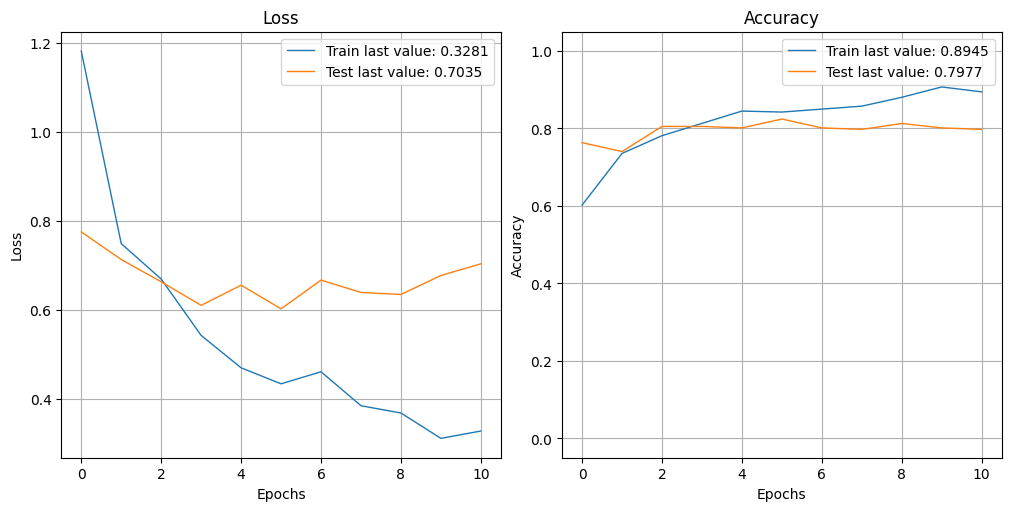

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history5)
plot_history(history5, path="standard.png")
plt.close()

## Dataframe résumant les résultats des modèles de classification

In [ ]:
result_model = pd.DataFrame(results_models)
result_model


,Modèle,Accuracy (Validation),Temps (Validation),Accuracy (Test),Temps (Test)
0,Modèle 1_approche initiale,0.809783,92.361774,0.796825,157.204915
1,Modèle 2_datagnerator,0.809783,181.054233,0.831746,211.614541
2,Modèle 3_dataset,0.738975,27.607943,0.738975,417.282687
3,Modèle 4_DataAugmentation_intégré,0.809783,59.245873,0.831746,487.696182
4,Modèle 5_EfficientNetB2,0.812977,49.956712,0.831746,57.189212
